In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display
from matplotlib.lines import Line2D


import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs
import cmocean

import scipy.signal as signal

# Options

In [2]:
regions = ['SEA', 'Indo','Malay','all_countries','Viet','Cambod']
months = ['Jan','Apr','July', 'Oct'] #options are Jan, Apr, July, Oct
time = '2016'
pulse_size = '2x'
#compare_2x = True #True allows for comparison to the 2x simulation to see the performance of the GF; False just creates a new GF
#global_mean = True #False turns on a spatially explicit version with lat and lon; True turns on a global weighted mean
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


In [3]:
region_colors = {'all_countries':'navy', 'Indo':'darkslategrey', 'Viet':'darksalmon', 'Malay':'plum', 'Cambod':'olivedrab'}

In [4]:
Indo_colors = {'Indo_Jan_Center':'teal', 'Indo_Jan_NW':'steelblue', 'Indo_Jan_SE':'lightskyblue', 'Indo_Jan':region_colors['Indo']}

In [5]:
Indo_time_colors = {'Indo_Jan_6':'teal', 'Indo_Jan_11':'lightseagreen', 'Indo_Jan_16':'mediumaquamarine', 'Indo_Jan_21':'paleturquoise', 'Indo_Jan':region_colors['Indo']}

## Import the Green's function

In [6]:
G = xr.open_dataset(f'Outputs/G_combined_new.nc', chunks = 'auto')

In [7]:
area_ds = xr.open_dataset(f'../GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.Emissions.20160101_0000z.nc4')

In [8]:
area_ds = utils.fix_area_ij_latlon(area_ds)


In [9]:
G_mean = G.weighted(area_ds['area']).mean(dim = ['lat','lon'])['BC_total'].isel(lev = 0)

## Indonesia Location Plot

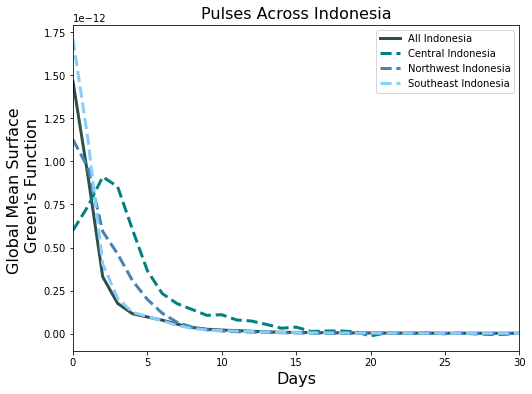

In [16]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
fig, ax = plt.subplots(figsize = [8,6])
label_dict = {'Indo_Jan':'All Indonesia','Indo_Jan_Center': 'Central Indonesia', 
              'Indo_Jan_NW': 'Northwest Indonesia', 'Indo_Jan_SE':'Southeast Indonesia'}

for r in ['Indo_Jan','Indo_Jan_Center','Indo_Jan_NW','Indo_Jan_SE']:
    if r == 'Indo_Jan':
        plt.plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = r), label = label_dict[r], color = Indo_colors[r], linewidth = 3)
    else:
        plt.plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = r), label = label_dict[r], color = Indo_colors[r], linewidth = 3, linestyle = 'dashed')
plt.xlim(0,30)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title("Pulses Across Indonesia", fontsize = 16)
plt.savefig('figures/Linearity_tests/indo_loc_plot.pdf', dpi = 250, bbox_inches = 'tight')

## Indonesia Time Plot

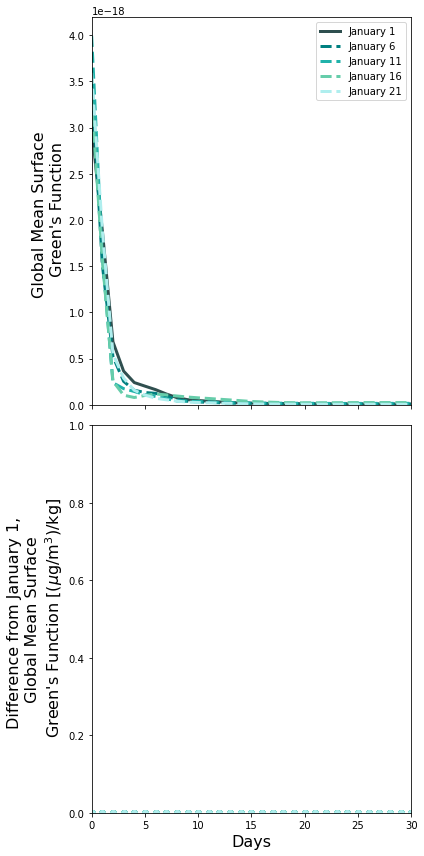

In [16]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
fig, (ax1, ax2) = plt.subplots(2,1,figsize = [6,8], sharex = True)

label_dict = {'Indo_Jan':'January 1','Indo_Jan_6': 'January 6','Indo_Jan_11': 'January 11',
             'Indo_Jan_16': 'January 16', 'Indo_Jan_21': 'January 21'}

for r in ['Indo_Jan','Indo_Jan_6','Indo_Jan_11','Indo_Jan_16','Indo_Jan_21',]:
    if r == 'Indo_Jan':
        ax1.plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = r), label = label_dict[r], color = Indo_time_colors[r], linewidth = 3)
    else:
        ax1.plot(np.arange(0,len(G_mean.sel(run = r)['time'])),G_mean.sel(run = r), label = label_dict[r], color = Indo_time_colors[r], linewidth = 3, linestyle = 'dashed')

plt.xlim(0,30)
plt.ylim(0, None)
ax1.legend()
#plt.xlabel('Days', fontsize = 16)
ax1.set_ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
#plt.title("Pulses At Varying Times in January in Indonesia", fontsize = 16)
#plt.savefig('figures/indo_time_plot.pdf', dpi = 250, bbox_inches = 'tight')
ax1.set_ylim(0,None)

for r in ['Indo_Jan_6','Indo_Jan_11','Indo_Jan_16','Indo_Jan_21',]:
    data = (G_mean.sel(run = r) - G_mean.sel(run = 'Indo_Jan'))#/G_mean.sel(run = 'Indo_Jan')
    ax2.plot(np.arange(0,len(data['time'])),data, color = Indo_time_colors[r], linewidth = 3, linestyle = 'None', marker = 'o')

plt.xlim(0,30)
#plt.legend()
ax2.set_xlabel('Days', fontsize = 16)
ax2.set_ylabel('Difference from January 1, \n Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', fontsize = 16)
#plt.title("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.tight_layout()
plt.savefig('figures/indo_dif_time_plot_both.pdf', dpi = 250, bbox_inches = 'tight')

## All Countries Summed vs. All Countries Pulsed

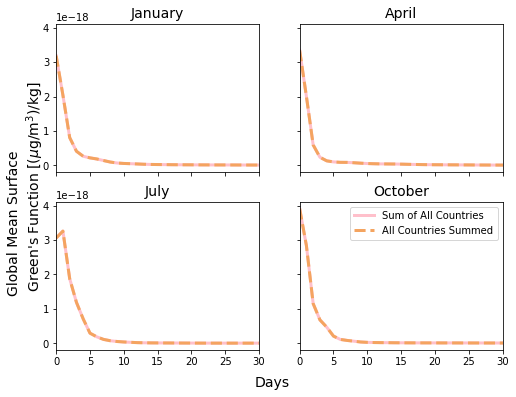

In [40]:
months_dict = {'Jan':'January','Apr':'April','July':'July','Oct':'October'}
fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, m in enumerate(['Jan','Apr','July','Oct']):
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = f'all_countries_summed_{m}'), label = 'Sum of All Countries', color = 'pink', linewidth = 3)
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = f'all_countries_{m}'), label = 'All Countries Summed', linestyle = '--', color = 'sandybrown', linewidth = 3)
    axes[idx].set_title(months_dict[m], fontsize = 14)
plt.xlim(0,30)
plt.legend()
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Sum of the Pulse vs. Pulse of the Sum for each Month", fontsize = 16)
plt.savefig('figures/ac_sum_vs_sum_ac.pdf', dpi = 250, bbox_inches = 'tight')

## SEA versus Individual Countries by Season

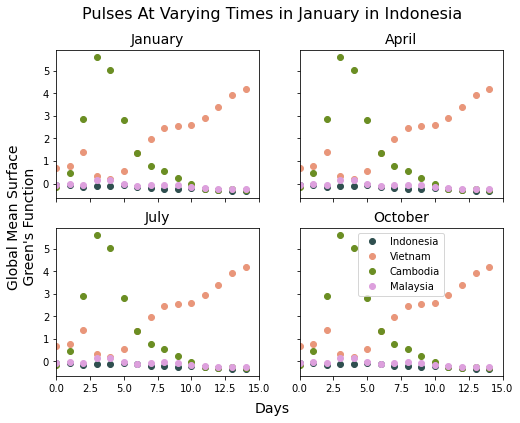

In [36]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia', 'SEA':'Southeast Asia'}


fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, m in enumerate(['Jan','Apr','July','Oct']):
    #axes[idx].plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = f'all_countries_{m}'), label = label_dict['SEA'], color = region_colors['SEA'], linewidth = 3)
    for c in ['Indo','Viet','Cambod','Malay']:
        data = (((G_mean.sel(run = f'{c}_Jan'))-G_mean.sel(run = 'all_countries_Jan'))/G_mean.sel(run = 'all_countries_Jan')).isel(time = slice(0,15))
        axes[idx].plot(np.arange(0,len(data['time'])), data, marker = 'o', label = label_dict[c], color = region_colors[c], linestyle = "None")
        axes[idx].set_title(months_dict[m], fontsize = 14)

plt.legend()
plt.xlim(0,15)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/ac_v_countries_dif.pdf', dpi = 250, bbox_inches = 'tight')

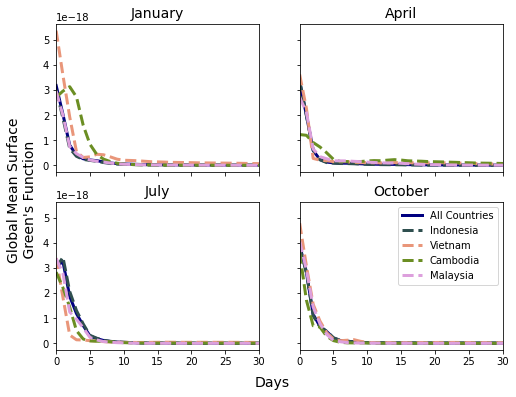

In [15]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia', 'all_countries':'All Countries'}
months_dict = {'Jan':'January','Apr':'April','July':'July','Oct':'October'}


fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, m in enumerate(['Jan','Apr','July','Oct']):
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'all_countries_{m}')['time'])), G_mean.sel(run = f'all_countries_{m}'), label = label_dict['all_countries'], color = region_colors['all_countries'], linewidth = 3)
    for c in ['Indo','Viet','Cambod','Malay']:
        axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'{c}_{m}')['time'])), G_mean.sel(run = f'{c}_{m}'), label = label_dict[c], color = region_colors[c], linewidth = 3, linestyle = '--')
        axes[idx].set_title(months_dict[m], fontsize = 14)

plt.legend()
plt.xlim(0,30)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/SEA_v_countries.pdf', dpi = 250, bbox_inches = 'tight')

## Combined linearity test

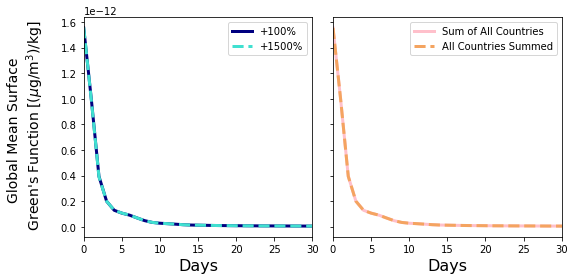

In [10]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'all_countries_Jan_16x':r'+1500%','all_countries_Jan': r'+100%'}
times_colors = {'all_countries_Jan_16x': 'turquoise','all_countries_Jan':'navy'}
months_dict = {'Jan':'January','Apr':'April','July':'July','Oct':'October'}
fig, (ax1, ax2) = plt.subplots(1,2,figsize = [8,4], sharey = True)

#16x v 2x
ax1.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan')['time'])), G_mean.sel(run = 'all_countries_Jan'), label = label_dict['all_countries_Jan'], 
         color = times_colors['all_countries_Jan'], linewidth = 3)
ax1.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan_16x')['time'])), G_mean.sel(run = 'all_countries_Jan_16x'), label = label_dict['all_countries_Jan_16x'], 
         color = times_colors['all_countries_Jan_16x'], linestyle = '--', linewidth = 3)

    
ax1.legend()
ax1.set_xlim(0,30)
ax1.set_xlabel('Days', fontsize = 16)
ax1.set_ylabel('Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', va='center', rotation='vertical', labelpad = -.3, fontsize = 14)
ax1.yaxis.set_label_coords(-0.25, 0.5)

#all countries summed
ax2.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_summed_Jan')['time'])), G_mean.sel(run = f'all_countries_summed_Jan'), label = 'Sum of All Countries', color = 'pink', linewidth = 3)
ax2.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan')['time'])), G_mean.sel(run = f'all_countries_Jan'), label = 'All Countries Summed', linestyle = '--', color = 'sandybrown', linewidth = 3)


ax2.set_xlim(0,30)
ax2.legend()
ax2.set_xlabel('Days', fontsize = 16)
plt.tight_layout()
#plt.suptitle("Sum of the Pulse vs. Pulse of the Sum for each Month", fontsize = 16)
plt.savefig('figures/linearity_tests.pdf', dpi = 250, bbox_inches = 'tight')


## 16x vs. 2x

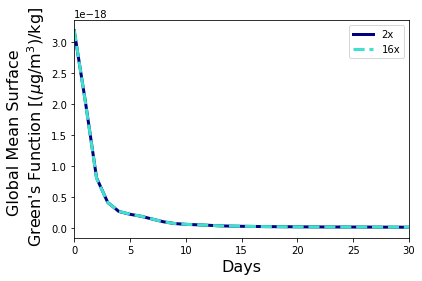

In [39]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
label_dict = {'all_countries_Jan_16x':'16x','all_countries_Jan': '2x'}
times_colors = {'all_countries_Jan_16x': 'turquoise','all_countries_Jan':'navy'}
plt.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan')['time'])), G_mean.sel(run = 'all_countries_Jan'), label = label_dict['all_countries_Jan'], 
         color = times_colors['all_countries_Jan'], linewidth = 3)
plt.plot(np.arange(0,len(G_mean.sel(run = 'all_countries_Jan_16x')['time'])), G_mean.sel(run = 'all_countries_Jan_16x'), label = label_dict['all_countries_Jan_16x'], 
         color = times_colors['all_countries_Jan_16x'], linestyle = '--', linewidth = 3)

    
plt.legend()
plt.xlim(0,30)
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', fontsize = 16)
#plt.title("16x and 2x pulses in All Countries, January", fontsize = 16)
plt.savefig('figures/16x_2x_jan_plot.pdf', dpi = 250, bbox_inches = 'tight')

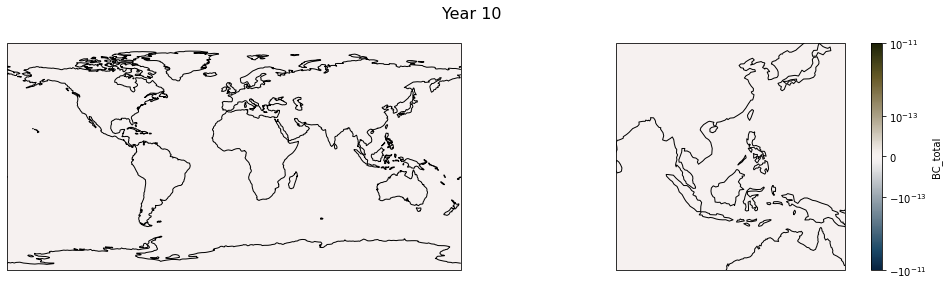

In [13]:
t = 10
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
data = (G.sel(run = 'all_countries_Jan_16x').isel(time = t, lev = 0) - 
  G.sel(run = 'all_countries_Jan').isel(time = t, lev = 0))['BC_total']
##### global view #######
(data).plot(ax = ax1, transform = ccrs.PlateCarree(),norm = SymLogNorm(1e-13, 1, -1e-11, 1e-11), 
            add_colorbar = False, cmap = cmocean.cm.diff)
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(data).plot(ax = ax2, transform = ccrs.PlateCarree(), 
            norm = SymLogNorm(1e-13, 1, -1e-11, 1e-11), cmap = cmocean.cm.diff)
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Year {t}', fontsize = 16);
plt.tight_layout()
plt.savefig(f"figures/16x_2x_map.png", dpi = 350, bbox_inches = 'tight')

## Mean Across Months vs. Individual Months by Country

In [16]:
for c in ['Indo','Viet','Cambod','Malay']:
    print(G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run').isel(time = slice(1,15)).diff(dim = 'time').values)

[-6.89512120e-13 -2.31903911e-13 -1.13807541e-13 -9.43595794e-14
 -3.24972509e-14 -1.98966118e-14 -1.40883825e-14 -9.63599020e-15
 -5.44585760e-15 -3.38382765e-15 -3.05448378e-15 -2.15977175e-15
 -1.50746446e-15]
[-8.41765579e-13 -2.87207411e-13 -8.87312655e-14 -3.57375807e-14
  3.16697898e-15 -2.97380579e-15 -1.22801142e-14 -2.36017925e-14
 -1.12640010e-14 -3.67806064e-15 -1.90283844e-15 -1.27518218e-15
 -2.02276511e-15]
[-2.30176069e-13 -1.91394723e-13 -2.49254340e-13 -1.54285306e-13
 -6.85417761e-14 -2.61506752e-14 -1.55866438e-14 -9.51429684e-15
 -3.39091314e-15 -1.75951921e-15 -2.52236539e-15  2.07878361e-15
  1.59032895e-15]
[-6.95832905e-13 -1.87083688e-13 -1.22986026e-13 -9.70778608e-14
 -2.43028206e-14 -1.60906596e-14 -1.19068883e-14 -7.73675446e-15
 -5.51160143e-15 -3.93038988e-15 -3.53078654e-15 -1.87363365e-15
 -9.31476764e-16]


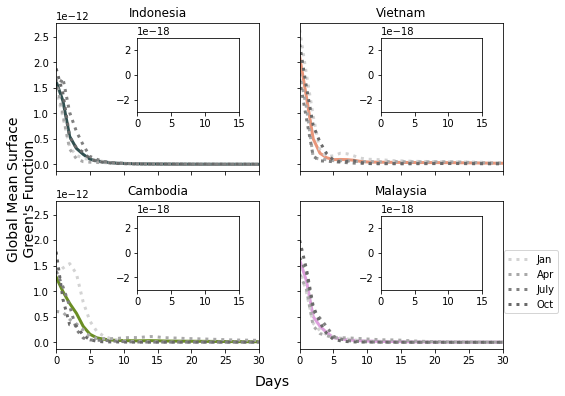

In [14]:
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia'}



fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = [8,6])
axes = axes.ravel()
for idx, c in enumerate(['Indo','Viet','Cambod','Malay']):
    axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'{c}_Jan')['time'])), G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run'), 
                   color = region_colors[c], linewidth = 3)
    colors = iter(['lightgrey','darkgrey', 'grey','dimgrey'])
    ##inset
    axins = axes[idx].inset_axes([.4,.4,.5,.5])
    for m in ['Jan','Apr','July','Oct']:
        col = next(colors)
        axes[idx].plot(np.arange(0,len(G_mean.sel(run = f'{c}_{m}')['time'])), G_mean.sel(run = f'{c}_{m}'), label = m, linestyle = ':', color = col, linewidth = 3)
        ##inset for the difference from the mean
        data = (G_mean.sel(run = f'{c}_{m}') - G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run'))#/G_mean.loc[G_mean.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')
        axins.plot(np.arange(0,len(data['time'])), data, color = col, linestyle = 'None', marker = '.')
        axins.set_xlim(0,15)
        axins.set_ylim(-3e-18,3e-18)
        
    axes[idx].set_title(label_dict[c])
    
custom_lines = [Line2D([0], [0], color='black', lw=3)]
axes[3].legend(custom_lines, ['Mean Across Months'])

plt.legend(bbox_to_anchor = (1.1, .5, .2, .2))
plt.xlim(0,30)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'Global Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/monthly_mean_v_months_country.pdf', dpi = 250, bbox_inches = 'tight')

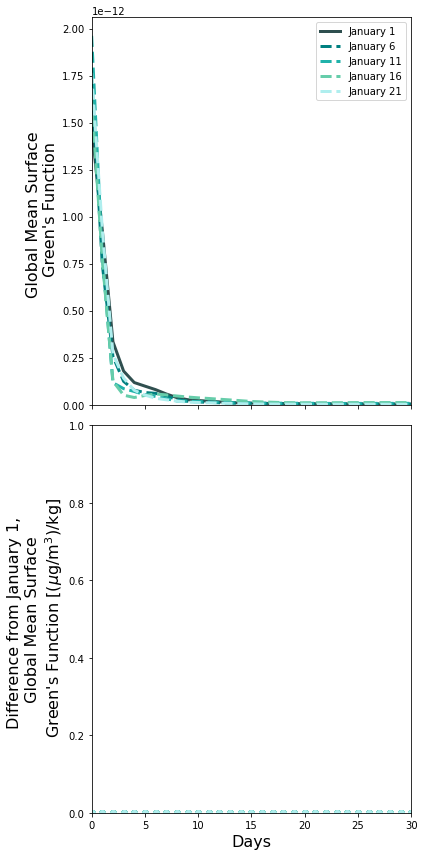

In [15]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
fig, (ax1, ax2) = plt.subplots(2,1,figsize = [6,12], sharex = True)

label_dict = {'Indo_Jan':'January 1','Indo_Jan_6': 'January 6','Indo_Jan_11': 'January 11',
             'Indo_Jan_16': 'January 16', 'Indo_Jan_21': 'January 21'}

for r in ['Indo_Jan','Indo_Jan_6','Indo_Jan_11','Indo_Jan_16','Indo_Jan_21',]:
    if r == 'Indo_Jan':
        ax1.plot(np.arange(0,len(G_mean.sel(run = r)['time'])), G_mean.sel(run = r), label = label_dict[r], color = Indo_time_colors[r], linewidth = 3)
    else:
        ax1.plot(np.arange(0,len(G_mean.sel(run = r)['time'])),G_mean.sel(run = r), label = label_dict[r], color = Indo_time_colors[r], linewidth = 3, linestyle = 'dashed')

plt.xlim(0,30)
plt.ylim(0, None)
ax1.legend()
#plt.xlabel('Days', fontsize = 16)
ax1.set_ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
#plt.title("Pulses At Varying Times in January in Indonesia", fontsize = 16)
#plt.savefig('figures/indo_time_plot.pdf', dpi = 250, bbox_inches = 'tight')
ax1.set_ylim(0,None)

for r in ['Indo_Jan_6','Indo_Jan_11','Indo_Jan_16','Indo_Jan_21',]:
    data = (G_mean.sel(run = r) - G_mean.sel(run = 'Indo_Jan'))#/G_mean.sel(run = 'Indo_Jan')
    ax2.plot(np.arange(0,len(data['time'])),data, color = Indo_time_colors[r], linewidth = 3, linestyle = 'None', marker = 'o')

plt.xlim(0,30)
#plt.legend()
ax2.set_xlabel('Days', fontsize = 16)
ax2.set_ylabel('Difference from January 1, \n Global Mean Surface \n Green\'s Function [($\mu$g/m$^3$)/kg]', fontsize = 16)
#plt.title("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.tight_layout()
plt.savefig('figures/indo_dif_time_plot_both.pdf', dpi = 250, bbox_inches = 'tight')

## China specific

In [34]:
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
country_impacted = 'China'


In [35]:
mask = country_mask.mask(G, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
country_impacted_ds = G.where(contiguous_mask)

In [12]:
mean_country_impact = country_impacted_ds.weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)

In [57]:
mean_country_impact.load()

<xarray.Dataset>
Dimensions:   (time: 124, run: 42)
Coordinates:
  * time      (time) timedelta64[ns] 0 days 1 days 2 days ... 122 days 123 days
    lev       float64 1.0
  * run       (run) object 'SEA_Jan' 'SEA_Apr' ... 'Indo_Jan_NW' 'Indo_Jan_SE'
Data variables:
    BC_total  (run, time) float64 3.051e-13 4.746e-13 3.304e-12 ... nan nan nan

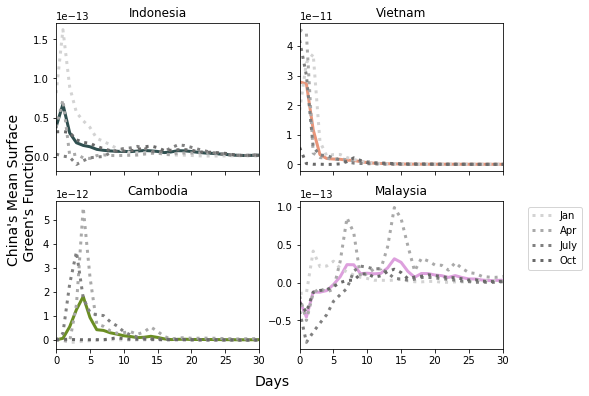

In [64]:
label_dict = {'Indo':'Indonesia', 'Malay':'Malaysia','Viet':'Vietnam','Cambod':'Cambodia'}



fig, axes = plt.subplots(2, 2, sharex = True, figsize = [8,6])
axes = axes.ravel()
for idx, c in enumerate(['Indo','Viet','Cambod','Malay']):
    axes[idx].plot(np.arange(0,len(mean_country_impact.sel(run = f'{c}_Jan')['time'])), mean_country_impact.loc[dict(run = [f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')['BC_total'], 
                   color = region_colors[c], linewidth = 3)
    colors = iter(['lightgrey','darkgrey', 'grey','dimgrey'])
    #inset
    #axins = axes[idx].inset_axes([.4,.4,.5,.5])
    for m in ['Jan','Apr','July','Oct']:
        col = next(colors)
        axes[idx].plot(np.arange(0,len(mean_country_impact.sel(run = f'{c}_{m}')['time'])), mean_country_impact.sel(run = f'{c}_{m}')['BC_total'], label = m, linestyle = ':', color = col, linewidth = 3)
        axes[idx].set_title(label_dict[c])
#         ##inset for the difference from the mean
#         data = (mean_country_impact.sel(run = f'{c}_{m}')['BC_total'] - mean_country_impact.loc[dict(run = [f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')['BC_total'])#/mean_country_impact.loc[mean_country_impact.run.isin([f'{c}_Jan', f'{c}_Apr', f'{c}_July', f'{c}_Oct'])].mean(dim = 'run')
#         axins.plot(np.arange(0,len(data['time'])), data, color = col, linestyle = 'None', marker = '.')
#         axins.set_xlim(0,15)
#         axins.set_ylim(-3e-18,3e-18)
        
         
    
custom_lines = [Line2D([0], [0], color='black', lw=3)]
axes[3].legend(custom_lines, ['Mean Across Months'])

plt.legend(bbox_to_anchor = (1.1, .5, .2, .2))
plt.xlim(0,30)
fig.text(0.5, 0.04, 'Days', ha='center', fontsize = 14)
fig.text(0.04, 0.5, 'China\'s Mean Surface \n Green\'s Function', va='center', rotation='vertical', fontsize = 14)
#plt.suptitle("Pulses At Varying Times in January in Indonesia", fontsize = 16)
plt.savefig('figures/china_monthly_mean_v_months_country.pdf', dpi = 250, bbox_inches = 'tight')

## Map

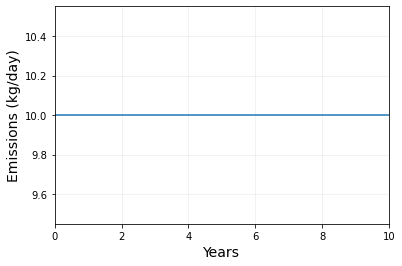

In [10]:
plt.plot(np.ones(11)*10)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('Emissions (kg/day)', fontsize = 14)
plt.grid(alpha = .2)
plt.xlim(0,10)
plt.savefig('figures/emis_ex.png', bbox_inches = 'tight', dpi = 350)

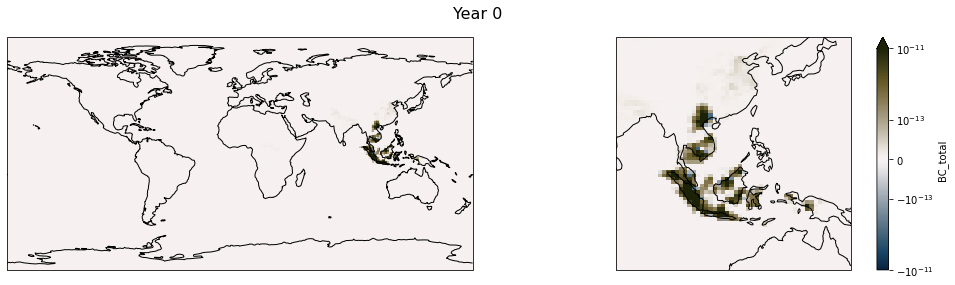

In [12]:
t = 0
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(G.sel(run = 'all_countries_Jan').isel(time = t, lev = 0)['BC_total']*10*365*10).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-13, 1, -1e-11, 1e-11), add_colorbar = False,
                                                                           cmap = cmocean.cm.diff)
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(G.sel(run = 'all_countries_Jan').isel(time = t, lev = 0)['BC_total']*10*365*10).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(1e-13, 1, -1e-11, 1e-11),
                                                                           cmap = cmocean.cm.diff)
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Year {t}', fontsize = 16);
plt.tight_layout()
#plt.savefig(f"figures/conv_explainer_time{t}.png", dpi = 350, bbox_inches = 'tight')

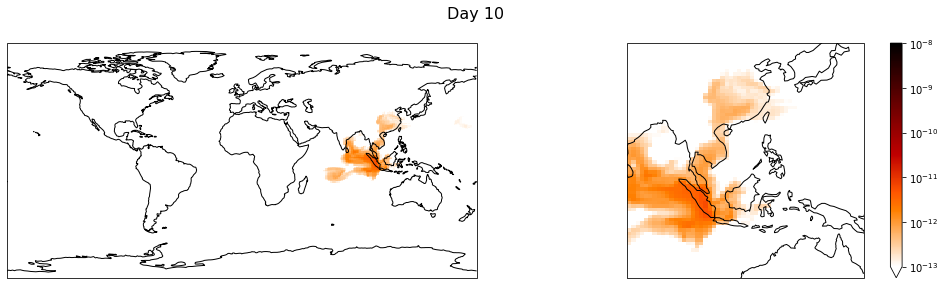

In [36]:
t = 10
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
##### global view #######
(G_lev0.isel(time = t, lev = 0)['BC_total']).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(5e-20, 1, 1e-13, 1e-8), add_colorbar = False,
                                                                           cmap = 'gist_heat_r')
ax1.coastlines()
ax1.set_title('')
##### Zoomed in ########
(G_lev0.isel(time = t, lev = 0)['BC_total']).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                            norm = SymLogNorm(5e-20, 1, 1e-13, 1e-8),
                                                                               cmap = 'gist_heat_r',
                                                                               cbar_kwargs = {'label':None})
ax2.coastlines()
ax2.add_feature(cfeat.STATES)
ax2.set_extent([80,150,-20,40])
ax2.set_title('')
plt.suptitle(f'Day {t}', fontsize = 16);
plt.tight_layout()
plt.savefig(f"figures/conv_explainer_time{t}.png", dpi = 350, bbox_inches = 'tight')

In [10]:
G_lev0 = G.sel(run = 'all_countries_Apr').where((G.sel(run = 'all_countries_Apr') > 0), drop = True)

## Video 3D

In [16]:
G_lev0.isel(time = t, lev = 0)

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 288)
Coordinates:
    time      timedelta64[ns] 2 days
  * lon       (lon) float64 -179.4 -178.1 -176.9 -175.6 ... 176.9 178.1 179.4
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lev       float64 1.0
    run       <U17 'all_countries_Apr'
Data variables:
    BC_total  (lat, lon) float64 dask.array<chunksize=(45, 72), meta=np.ndarray>

In [30]:
for t in np.arange(0,25):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
    ##### global view #######
    (G_lev0.isel(time = t, lev = 0)['BC_total']).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                                norm = SymLogNorm(5e-20, 1, 1e-13, 1e-8), add_colorbar = False,
                                                                               cmap = 'gist_heat_r')
    ax1.coastlines()
    ax1.set_title('')
    ##### Zoomed in ########
    (G_lev0.isel(time = t, lev = 0).fillna(0)['BC_total']).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                                norm = SymLogNorm(5e-20, 1, 1e-13, 1e-8),
                                                                               cmap = 'gist_heat_r',
                                                                               cbar_kwargs = {'label':None})
    ax2.coastlines()
    ax2.add_feature(cfeat.STATES)
    ax2.set_extent([80,150,-20,40])
    ax2.set_title('')
    plt.suptitle(f'Day {t}', fontsize = 16);
    plt.tight_layout()
    plt.savefig("figures/GF_video/" + str(t).zfill(4) + ".png", dpi = 150, bbox_inches = 'tight')
    plt.close();

## Convolved 2x vs. step output for Indonesia

In [10]:
pulse_size = '16x'

#2x pulse for GF
Jan_2x_conc = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/Indo_cos/2x_jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')
Jan_2x_emis = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/Indo_cos/2x_jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
#base
base_emis = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
base_conc = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')


In [11]:
Jan_2x_dif = Jan_2x_conc - base_conc

In [12]:
emis_dif = Jan_2x_emis - base_emis

In [13]:
#modify data
Jan_2x_dif['time'] = Jan_2x_dif['time'].astype('datetime64')
utils.switch_conc_time(Jan_2x_dif)
#fix the area
Jan_2x_dif = utils.fix_area_ij_latlon(Jan_2x_dif)
#sum all BC conc
Jan_2x_dif['BC_total'] = Jan_2x_dif['SpeciesConc_BCPI'] + Jan_2x_dif['SpeciesConc_BCPO']

In [14]:

emis_dif = utils.fix_area_ij_latlon(emis_dif)
emis_dif = emis_dif.isel(lev = -1) #select surface since we only have surface emissions
utils.combine_BC(emis_dif)


### Add height to data
height_ds = utils.height_ds
Jan_2x_dif = xr.merge([Jan_2x_dif, height_ds], join = 'inner')



In [15]:

### convert to correct units
def ppb_to_ug(ds, species_to_convert, mw_species_list, P, T):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    mol_per_m3= (P / (T * R)) #Pa/K/(J/K/mol) = mol/m3
    
    for spec in species_to_convert:
        attrs = ds[spec].attrs
        ds[spec] = ds[spec]*mw_species_list[spec]*mol_per_m3*1e-3 #ppb*g/mol*mol/m3*ug/ng
        ds[spec].attrs['units'] = 'μg m-3'



In [16]:
mw_BC = {'BC_total':12.011}

T_p_ds = xr.open_mfdataset('/net/geoschem/data/gcgrid/data/ExtData/GEOS_0.5x0.625/MERRA2/2016/*/MERRA2.2016*.I3.05x0625.nc4')
T_p_ds = T_p_ds.groupby('time.date').mean(dim = 'time').rename({'date':'time'})

#create regridder (reusing weights)
regridder = xe.Regridder(T_p_ds, Jan_2x_dif, 'bilinear', reuse_weights = True, weights = 'tp_bilinear_weights.nc')
regridder  # print basic regridder information.

#regrid according to our ds_out grid
T_p_ds = regridder(T_p_ds)
T_p_ds = T_p_ds.isel(time = slice(0, len(Jan_2x_dif['time'])))
T_p_ds['time'] = Jan_2x_dif['time']

pressure_ds = utils.pressure_ds

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [17]:
Jan_2x_dif['BC_total'] = Jan_2x_dif['BC_total']*1e9 #convert mol/mol to ppb
ppb_to_ug(Jan_2x_dif, ['BC_total'], mw_BC, pressure_ds, T_p_ds['T'])

In [18]:
emis_profile = emis_dif.weighted(area_ds['area']).sum(dim = ['lat','lon'])['EmisBC_Total']

In [19]:
G_lev0 = G.sel(run = 'Indo_Jan').isel(lev = 0)['BC_total']

In [20]:
G_lev0 = G_lev0.rename({'time':'s'})

In [21]:
conv_viet_2x = signal.convolve(np.array(G_lev0.fillna(0)) , np.array(emis_profile.values)[..., None, None], mode = 'full')


In [22]:
def np_to_xr(C, G, E):
    E_len = len(E)
    G_len = len(G.s)
    C = xr.DataArray(
    data = C,
    dims = ['s','lat','lon'],
    coords = dict(
        s = (['s'], np.arange(0, C.shape[0])), #np.arange(0,(E_len+G_len))),
        lat = (['lat'], G.lat.values),
        lon = (['lon'], G.lon.values)
            )
        )
    return(C)

In [23]:
conv_viet_2x_ds = np_to_xr(conv_viet_2x, G_lev0, np.array(emis_profile))

In [24]:
countries = ['China']#,'Australia', 'India']#'Myanmar', 'Laos','Philippines','Nepal','Bangladesh',
             #'Thailand','Bhutan','Brunei', 'Papua New Guinea', 'Solomon Is.', 'Timor-Leste', 'Taiwan']

In [25]:
indiv_country_conv_ds = {}
indiv_country_2x_ds = {}

indiv_country_conv = {}
indiv_country_2x = {}

for country_impacted in countries:
    ## Mask to individual countries
    country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
    mask = country_mask.mask(conv_viet_2x_ds, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
    indiv_country_conv_ds[country_impacted] = conv_viet_2x_ds.where(contiguous_mask)
    indiv_country_2x_ds[country_impacted] = Jan_2x_dif.where(contiguous_mask)

    ##china mean##
    indiv_country_conv[country_impacted] = indiv_country_conv_ds[country_impacted].weighted(area_ds['area']).mean(dim = ['lat','lon'])
    indiv_country_2x[country_impacted] = indiv_country_2x_ds[country_impacted].weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)


In [26]:
##global mean##
full_conv = conv_viet_2x_ds.weighted(area_ds['area']).mean(dim = ['lat','lon'])
full_2x = Jan_2x_dif.weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)

In [ ]:
indiv_country_conv[country_impacted].plot()

In [ ]:
indiv_country_2x[country_impacted]['BC_total'].plot()

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (20,8), sharex = True, sharey = False)
for ax, impacted_c in zip(axes.ravel(), countries):
    ax.plot(indiv_country_conv[country_impacted], label = 'GCGF', color = 'maroon')
    ax.plot(indiv_country_2x[country_impacted]['BC_total'], linestyle = '--', label = 'Model Output', color = 'teal')
    ax.set_title('China Mean')
    ax.set_ylabel('ng/m$^3$', fontsize = 14)
    ax.set_xlabel('Days', fontsize = 14)
    ax.legend()
    ax.set_xlim(0,45)

ax1 = axes[3,3]
ax1.plot(full_conv, label = 'GCGF', color = 'maroon')
ax1.plot(full_2x['BC_total'], linestyle = '--', label = 'Model Output', color = 'teal')
ax1.set_ylabel('ng/m$^3$', fontsize = 14)
ax1.set_xlabel(None)
ax1.set_title('Global Mean')
ax1.set_xlim(0,45)



#plt.savefig('figures/paper/GCGF_recreation.png', bbox_inches = 'tight', dpi = 350)

In [42]:
def rmse(ds_obs, ds_expected, time):
    ds_obs = ds_obs.isel(s = slice(0, time))
    ds_expected = ds_expected.rename({'time':'s'}).isel(s = slice(0, time))
    ds_expected['s'] = np.arange(0,len(ds_expected['s']))
    rmse = np.sqrt(((ds_expected - ds_obs)**2).sum(dim = 's')/len(((ds_expected - ds_obs)**2)['s']))
    return(rmse)

In [45]:
indiv_country_conv[country_impacted]

<xarray.DataArray (s: 134)>
array([9.07624273e-07, 2.71527718e-06, 3.70414414e-06, 4.32972359e-06,
       4.84206990e-06, 5.25916174e-06, 5.52110773e-06, 5.74235576e-06,
       5.91239984e-06, 6.02985396e-06, 6.11688432e-06, 6.17473371e-06,
       6.23238069e-06, 6.28858357e-06, 6.34713776e-06, 6.40120821e-06,
       6.43386871e-06, 6.45910729e-06, 6.48306579e-06, 6.50561467e-06,
       6.52369350e-06, 6.53690289e-06, 6.54677390e-06, 6.55706712e-06,
       6.56728270e-06, 6.57981824e-06, 6.59408525e-06, 6.60777093e-06,
       6.62010249e-06, 6.63267792e-06, 6.64361984e-06, 6.65459601e-06,
       6.66851140e-06, 6.68111188e-06, 6.69608023e-06, 6.71167640e-06,
       6.72718806e-06, 6.74346708e-06, 6.76053207e-06, 6.77701458e-06,
       6.79484068e-06, 6.80926729e-06, 6.82128983e-06, 6.83142930e-06,
       6.83881803e-06, 6.84700471e-06, 6.85679537e-06, 6.86755942e-06,
       6.87664828e-06, 6.88587812e-06, 6.89453160e-06, 6.90322069e-06,
       6.91193395e-06, 6.92020448e-06, 6.92809452e-06, 6.93620042e-06,
       6.94384767e-06, 6.95131170e-06, 6.95839387e-06, 6.05782689e-06,
       4.25366578e-06, 3.26654252e-06, 2.64183148e-06, 2.12991414e-06,
       1.71303255e-06, 1.45119045e-06, 1.22999212e-06, 1.05997148e-06,
       9.42528425e-07, 8.55503065e-07, 7.97656003e-07, 7.40009664e-07,
       6.83805641e-07, 6.25250176e-07, 5.71178527e-07, 5.38517334e-07,
       5.13278289e-07, 4.89319401e-07, 4.66770197e-07, 4.48691120e-07,
       4.35481626e-07, 4.25610584e-07, 4.15317311e-07, 4.05101696e-07,
       3.92566038e-07, 3.78298852e-07, 3.64613021e-07, 3.52281334e-07,
       3.39705764e-07, 3.28763739e-07, 3.17812293e-07, 3.03946066e-07,
       2.91372336e-07, 2.76420710e-07, 2.60838138e-07, 2.45337476e-07,
       2.29065177e-07, 2.12005778e-07, 1.95527462e-07, 1.77704087e-07,
       1.63279465e-07, 1.51258177e-07, 1.41120011e-07, 1.33732615e-07,
       1.25547311e-07, 1.15757862e-07, 1.04994410e-07, 9.59059952e-08,
       8.66765562e-08, 7.80234557e-08, 6.93346290e-08, 6.06214931e-08,
       5.23510013e-08, 4.44610228e-08, 3.63551873e-08, 2.87080652e-08,
       2.12442224e-08, 1.41622386e-08, 7.08025480e-09, 3.53926290e-09,
       1.76876695e-09, 8.83518976e-10, 4.40894988e-10, 2.19582994e-10,
       1.08926997e-10, 5.35989985e-11, 2.59349993e-11, 1.21029997e-11,
       5.18699986e-12, 1.72899995e-12, 3.93540072e-22, 4.07700112e-22,
       2.25635086e-22, 2.58264895e-22])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 125 126 127 128 129 130 131 132 133

In [40]:
indiv_country_2x[country_impacted]['BC_total']

<xarray.DataArray 'BC_total' (time: 59)>
dask.array<getitem, shape=(59,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-02-28T12:00:00
    lev      float64 1.0

In [44]:
rmse(indiv_country_conv[country_impacted], indiv_country_2x[country_impacted]['BC_total'], 60).values

array(3.85551591e-06)

In [46]:
rmse(full_conv, full_2x['BC_total'], 60).values

array(7.6797285e-06)

## Compare to cos

In [37]:
pulse_size = '16x'

#2x pulse for GF
Jan_cos_conc = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/Indo_cos/cos_jan/mod_outputs/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')
Jan_cos_emis = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_step/Indo_cos/cos_jan/mod_outputs/GEOSChem.Emissions.2016*', combine = 'by_coords')
#base
base_emis = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.Emissions.2016*', combine = 'by_coords')
base_conc = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan/mod_output/GEOSChem.SpeciesConc.2016*', combine = 'by_coords')


In [38]:
Jan_cos_dif = Jan_cos_conc - base_conc

In [39]:
emis_cos_dif = Jan_cos_emis - base_emis

In [40]:
#modify data
Jan_cos_dif['time'] = Jan_cos_dif['time'].astype('datetime64')
utils.switch_conc_time(Jan_cos_dif)
#fix the area
Jan_cos_dif = utils.fix_area_ij_latlon(Jan_cos_dif)
#sum all BC conc
Jan_cos_dif['BC_total'] = Jan_cos_dif['SpeciesConc_BCPI'] + Jan_cos_dif['SpeciesConc_BCPO']

In [41]:

emis_cos_dif = utils.fix_area_ij_latlon(emis_cos_dif)
emis_cos_dif = emis_cos_dif.isel(lev = -1) #select surface since we only have surface emissions
utils.combine_BC(emis_cos_dif)


### Add height to data
height_ds = utils.height_ds
Jan_cos_dif = xr.merge([Jan_cos_dif, height_ds], join = 'inner')



In [42]:

### convert to correct units
def ppb_to_ug(ds, species_to_convert, mw_species_list, P, T):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    mol_per_m3= (P / (T * R)) #Pa/K/(J/K/mol) = mol/m3
    
    for spec in species_to_convert:
        attrs = ds[spec].attrs
        ds[spec] = ds[spec]*mw_species_list[spec]*mol_per_m3*1e-3 #ppb*g/mol*mol/m3*ug/ng
        ds[spec].attrs['units'] = 'μg m-3'



In [43]:
mw_BC = {'BC_total':12.011}

T_p_ds = xr.open_mfdataset('/net/geoschem/data/gcgrid/data/ExtData/GEOS_0.5x0.625/MERRA2/2016/*/MERRA2.2016*.I3.05x0625.nc4')
T_p_ds = T_p_ds.groupby('time.date').mean(dim = 'time').rename({'date':'time'})

#create regridder (reusing weights)
regridder = xe.Regridder(T_p_ds, Jan_cos_dif, 'bilinear', reuse_weights = True, weights = 'tp_bilinear_weights.nc')
regridder  # print basic regridder information.

#regrid according to our ds_out grid
T_p_ds = regridder(T_p_ds)
T_p_ds = T_p_ds.isel(time = slice(0, len(Jan_cos_dif['time'])))
T_p_ds['time'] = Jan_cos_dif['time']

pressure_ds = utils.pressure_ds

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [44]:
Jan_cos_dif['BC_total'] = Jan_cos_dif['BC_total']*1e9 #convert mol/mol to ppb
ppb_to_ug(Jan_cos_dif, ['BC_total'], mw_BC, pressure_ds, T_p_ds['T'])

In [45]:
emis_cos_profile = emis_cos_dif.weighted(area_ds['area']).sum(dim = ['lat','lon'])['EmisBC_Total']

In [46]:
G_lev0 = G.sel(run = 'Indo_Jan').isel(lev = 0)['BC_total']
G_lev0 = G_lev0.where((G_lev0 > 0), drop = True)

In [55]:
G_lev0 = G_lev0.rename({'time':'s'})

In [56]:
conv_viet_cos = signal.convolve(np.array(G_lev0.fillna(0)) , np.array(emis_cos_profile.values)[..., None, None], mode = 'full')


In [57]:
conv_viet_cos_ds = np_to_xr(conv_viet_cos, G_lev0, np.array(emis_cos_profile))

In [116]:
indiv_country_conv_cos_ds = {}
indiv_country_cos_ds = {}
indiv_src_receptor_ds = {}

indiv_country_conv_cos = {}
indiv_country_cos = {}
indiv_src_receptor = {}
contiguous_mask = {}

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
mask = country_mask.mask(conv_viet_cos_ds, lon_name = 'lon', lat_name = 'lat')

for country_impacted in countries:
    ## Mask to individual countries

    contiguous_mask[country_impacted] = ~np.isnan(mask)& (mask == country_mask.map_keys(country_impacted))
    indiv_country_conv_cos_ds[country_impacted] = conv_viet_cos_ds.where(contiguous_mask[country_impacted])
    indiv_country_cos_ds[country_impacted] = Jan_cos_dif.where(contiguous_mask[country_impacted])
    indiv_src_receptor_ds[country_impacted] = src_receptor_apprch.where(contiguous_mask[country_impacted])
    
    a_loc_ds = area_ds['area'].where(contiguous_mask[country_impacted]).fillna(0)
    
    ##china mean##
    indiv_country_conv_cos[country_impacted] = indiv_country_conv_cos_ds[country_impacted].weighted(a_loc_ds).mean(dim = ['lat','lon'])
    indiv_country_cos[country_impacted] = indiv_country_cos_ds[country_impacted].weighted(a_loc_ds).mean(dim = ['lat','lon']).isel(lev = 0)
    indiv_src_receptor[country_impacted] = indiv_src_receptor_ds[country_impacted].weighted(a_loc_ds).mean(dim = ['lat','lon'])
    print(country_impacted)


China
Australia
India


In [59]:
##global mean##
full_conv_cos = conv_viet_cos_ds.weighted(area_ds['area']).mean(dim = ['lat','lon'])
full_cos = Jan_cos_dif.weighted(area_ds['area']).mean(dim = ['lat','lon']).isel(lev = 0)

In [106]:
## compare to the percent change
Jan_2x_dif['time']= emis_profile['time']
src_receptor_apprch = (Jan_2x_dif['BC_total'].isel(lev = 0)/emis_profile)

In [107]:
mean_src_receptor_apprch = src_receptor_apprch.weighted(area_ds['area']).mean(dim = ['lat','lon'])

(0.0, 14.0)

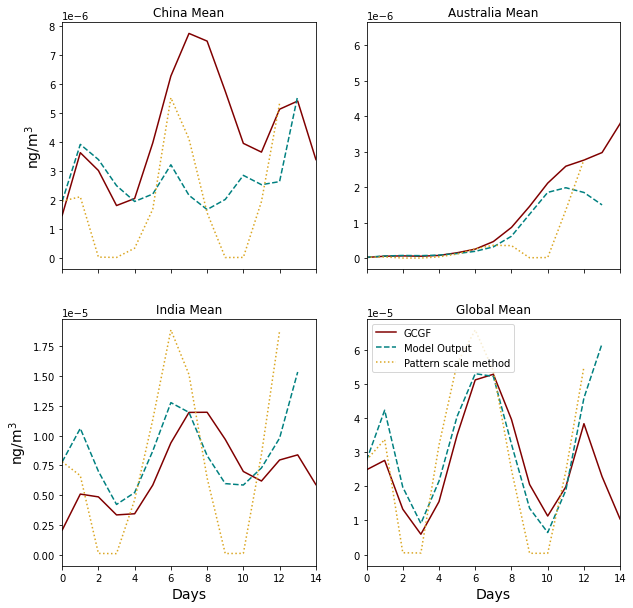

In [117]:
fig, axes = plt.subplots(2,2, figsize = (10,10), sharex = True, sharey = False)
for ax, country_impacted in zip(axes.ravel(), countries):
    ax.plot(indiv_country_conv_cos[country_impacted], label = 'GCGF', color = 'maroon')
    ax.plot(indiv_country_cos[country_impacted]['BC_total'], linestyle = '--', label = 'Model Output', color = 'teal')
    ax.plot(indiv_src_receptor[country_impacted]*emis_cos_profile, linestyle = ':', label = 'Pattern scale method', color = 'goldenrod')
    ax.set_title(f'{country_impacted} Mean')
    ax.set_ylabel(None)
    ax.set_xlabel(None)    
    
    axes[0,0].set_ylabel('ng/m$^3$', fontsize = 14)
    axes[1,0].set_ylabel('ng/m$^3$', fontsize = 14)
    axes[1,0].set_xlabel('Days', fontsize = 14)
    #ax.legend()
    ax.set_xlim(0,14)

ax1 = axes[1,1]
ax1.plot(full_conv_cos, label = 'GCGF', color = 'maroon')
ax1.plot(full_cos['BC_total'], linestyle = '--', label = 'Model Output', color = 'teal')
ax1.plot(mean_src_receptor_apprch*emis_cos_profile, linestyle = ':', label = 'Pattern scale method', color = 'goldenrod')
ax1.legend()
ax1.set_ylabel(None)
ax1.set_xlabel('Days', fontsize = 14)
ax1.set_title('Global Mean')
ax1.set_xlim(0,14)



#plt.savefig('figures/paper/GCGF_recreation.png', bbox_inches = 'tight', dpi = 350)

## Maps

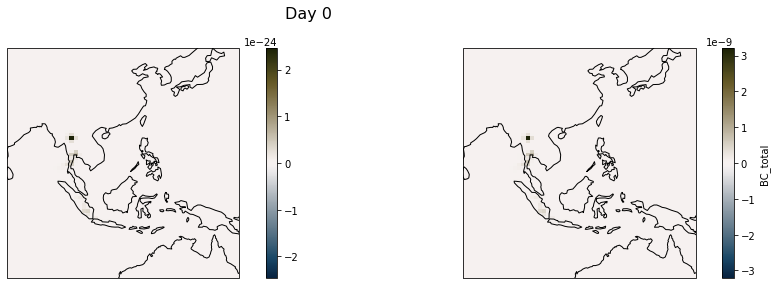

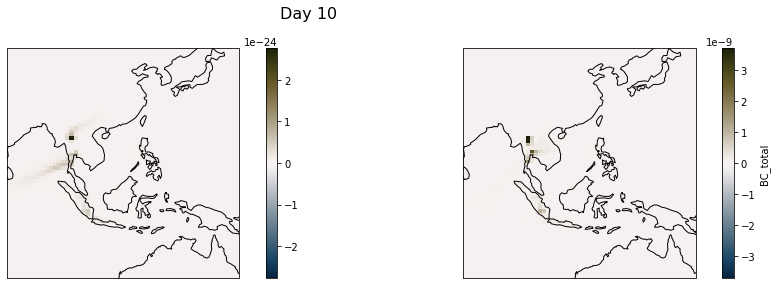

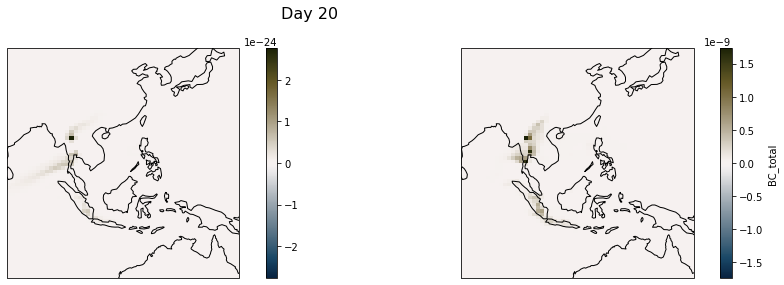

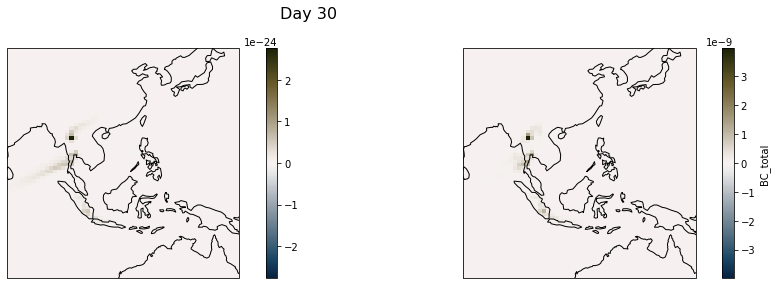

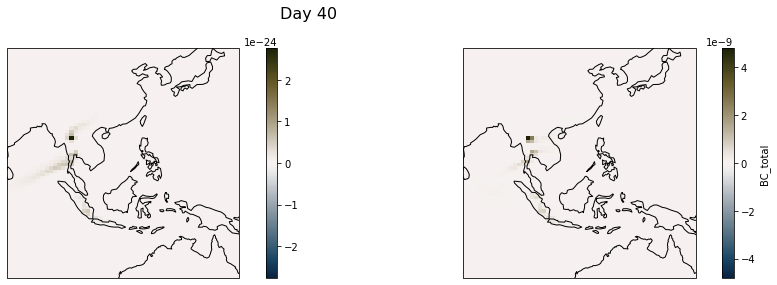

In [ ]:
for t in [0,10,20,30,40]:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
    ##### global view #######
    (conv_16x.isel(s = t)).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                                #norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16), add_colorbar = False,
                                                                               cmap = cmocean.cm.diff)
    ax1.coastlines()
    ax1.set_title('')
    ax1.set_extent([80,150,-20,40])
    ##### Zoomed in ########
    (Jan_2x_dif.isel(lev = 0).isel(s = t)['BC_total']).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                                #norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16),
                                                                               cmap = cmocean.cm.diff)
    ax2.coastlines()
    ax2.add_feature(cfeat.STATES)
    ax2.set_extent([80,150,-20,40])
    ax2.set_title('')
    plt.suptitle(f'Day {t}', fontsize = 16);
    plt.tight_layout()
    #plt.savefig("figures/GF_video/" + str(t).zfill(4) + ".png", dpi = 350, bbox_inches = 'tight')
    #plt.close();

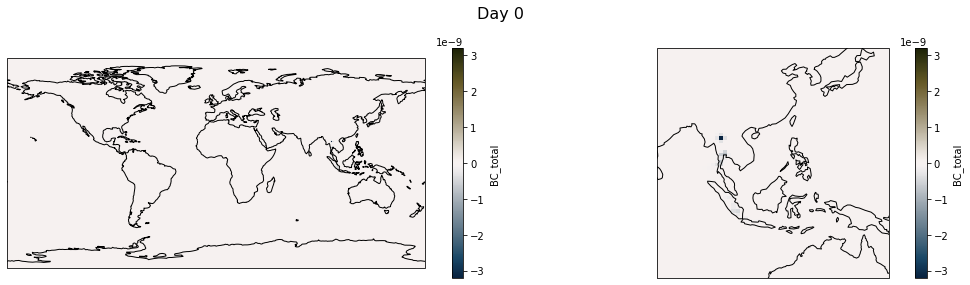

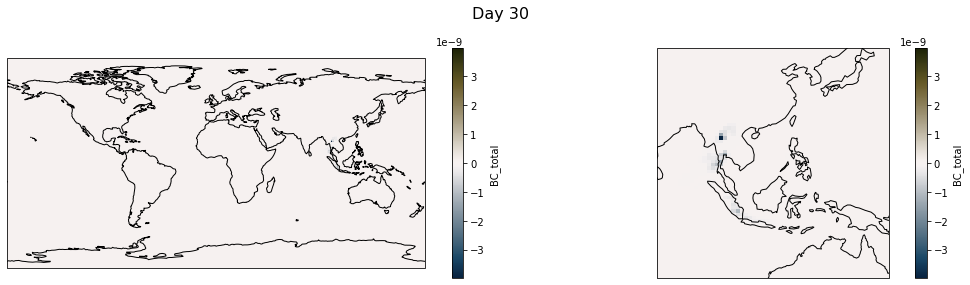

In [139]:
for t in [0,30]:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = [14,4], subplot_kw={'projection':ccrs.PlateCarree()})
    ##### global view #######
    ((conv_16x - Jan_2x_dif.isel(lev = 0)).isel(s = t)['BC_total']).plot(ax = ax1, transform = ccrs.PlateCarree(), 
                                                                                #norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16), add_colorbar = False,
                                                                               cmap = cmocean.cm.diff)
    ax1.coastlines()
    ax1.set_title('')
    ##### Zoomed in ########
    ((conv_16x - Jan_2x_dif.isel(lev = 0)).isel(s = t)['BC_total']).plot(ax = ax2, transform = ccrs.PlateCarree(), 
                                                                                #norm = SymLogNorm(1e-19, 1, -1e-16, 1e-16),
                                                                               cmap = cmocean.cm.diff)
    ax2.coastlines()
    ax2.add_feature(cfeat.STATES)
    ax2.set_extent([80,150,-20,40])
    ax2.set_title('')
    plt.suptitle(f'Day {t}', fontsize = 16);
    plt.tight_layout()
    #plt.savefig("figures/GF_video/" + str(t).zfill(4) + ".png", dpi = 350, bbox_inches = 'tight')
    #plt.close();

In [122]:
mean_conv = conv_16x.weighted(area_ds['area']).mean(dim = ['lat','lon'])

In [123]:
mean_Jan_dif_2x = Jan_2x_dif.isel(lev = 0).weighted(area_ds['area']).mean(dim = ['lat','lon'])

In [131]:
mean_Jan_dif_2x['BC_total'].values

array([4.62559058e-13, 1.03921991e-12, 1.37072751e-12, 1.52857213e-12,
       1.48235477e-12, 1.44907017e-12, 1.49750820e-12, 1.54353734e-12,
       1.37242098e-12, 1.27490574e-12, 1.29468341e-12, 1.47640733e-12,
       1.30168689e-12, 1.25578198e-12, 1.24840695e-12, 1.22092281e-12,
       1.29599895e-12, 1.31671658e-12, 1.32294338e-12, 1.46578036e-12,
       1.37806546e-12, 1.40310767e-12, 1.26353623e-12, 1.19089135e-12,
       1.27036428e-12, 1.48042066e-12, 1.62549114e-12, 1.83555084e-12,
       1.46682022e-12, 1.38953301e-12, 1.62189997e-12, 1.79579882e-12,
       1.83535941e-12, 1.89489927e-12, 1.78841972e-12, 1.93889228e-12,
       2.14208744e-12, 2.33479193e-12, 2.36127127e-12, 2.17676486e-12,
       2.00316407e-12, 1.84275857e-12, 1.74312412e-12, 1.67150203e-12,
       1.80295285e-12, 1.89750704e-12, 1.99018413e-12, 1.86499797e-12,
       2.09409963e-12, 2.17904606e-12, 1.87669311e-12, 1.74146836e-12,
       1.73599422e-12, 1.80409878e-12, 1.98698628e-12, 2.02510880e-12])

In [128]:
mean_conv

<xarray.DataArray (s: 111)>
array([1.05049713e-32, 1.88406345e-32, 2.47033967e-32, 2.87687395e-32,
       3.06837812e-32, 3.17693329e-32, 3.26663917e-32, 3.34215006e-32,
       3.40366469e-32, 3.45055532e-32, 3.48807092e-32, 3.52166506e-32,
       3.55120763e-32, 3.57612585e-32, 3.59669118e-32, 3.61539428e-32,
       3.63241988e-32, 3.64800969e-32, 3.66300063e-32, 3.67758623e-32,
       3.69141796e-32, 3.70436800e-32, 3.71679438e-32, 3.72860216e-32,
       3.73958786e-32, 3.74987373e-32, 3.75970423e-32, 3.76890833e-32,
       3.77741467e-32, 3.78544102e-32, 3.79304830e-32, 3.80024190e-32,
       3.80699665e-32, 3.81328277e-32, 3.81913289e-32, 3.82463235e-32,
       3.82976756e-32, 3.83450277e-32, 3.83887548e-32, 3.84291252e-32,
       3.84665331e-32, 3.85014564e-32, 3.85342000e-32, 3.85648329e-32,
       3.85935061e-32, 3.86202913e-32, 3.86450230e-32, 3.86678290e-32,
       3.86888042e-32, 3.87081866e-32, 3.87262654e-32, 3.87430654e-32,
       3.87586264e-32, 3.87729788e-32, 3.87862728e-32, 3.87986602e-32,
       2.82943317e-32, 1.99591778e-32, 1.40967725e-32, 1.00316761e-32,
       8.11674833e-33, 7.03125968e-33, 6.13425265e-33, 5.37918694e-33,
       4.76407540e-33, 4.29519506e-33, 3.92005956e-33, 3.58413632e-33,
       3.28872657e-33, 3.03955758e-33, 2.83391492e-33, 2.64689357e-33,
       2.47664630e-33, 2.32075619e-33, 2.17085453e-33, 2.02500610e-33,
       1.88669608e-33, 1.75720243e-33, 1.63294522e-33, 1.51487370e-33,
       1.40502242e-33, 1.30216920e-33, 1.20386947e-33, 1.11183342e-33,
       1.02612723e-33, 9.45354442e-34, 8.68924757e-34, 7.96742403e-34,
       7.29080923e-34, 6.66156668e-34, 6.07603685e-34, 5.52565934e-34,
       5.01179066e-34, 4.53800913e-34, 4.10053350e-34, 3.69664727e-34,
       3.32240938e-34, 2.97304441e-34, 2.64550155e-34, 2.33907601e-34,
       2.05225662e-34, 1.78432469e-34, 1.53693071e-34, 1.30879541e-34,
       1.09897081e-34, 9.05078304e-35, 7.24225527e-35, 5.56162210e-35,
       4.00494795e-35, 2.56915731e-35, 1.23923307e-35])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 102 103 104 105 106 107 108 109 110